In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
import time
%matplotlib inline
import sys
sys.path.append('./')

# from intersections_and_roads import *
from final_project import *
# from search import *
from shapely.geometry import *
import ast

**Cambridge Graph**

In [2]:
cambridge_map = map_structure(city='Cambridge')

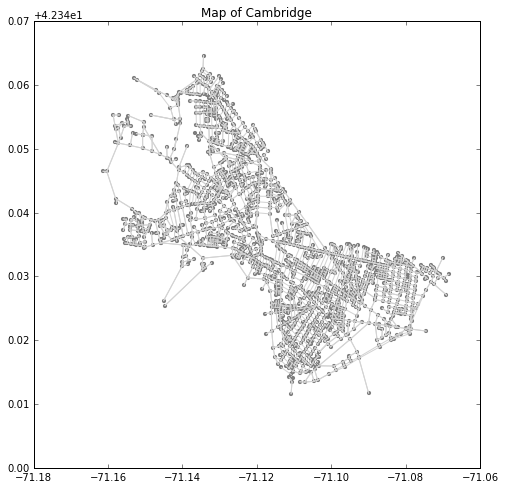

In [3]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
cambridge_map.plot_graph(ax=ax)
ax.set_title('Map of Cambridge')
plt.show()

In [4]:
print 'number of accidents in Cambridge', np.sum([val.get_accidents() for key, val in cambridge_map.road_connections.iteritems()])

number of accidents in Cambridge 876


**San Francisco**

In [5]:
san_fran_map = map_structure(city='San Francisco')

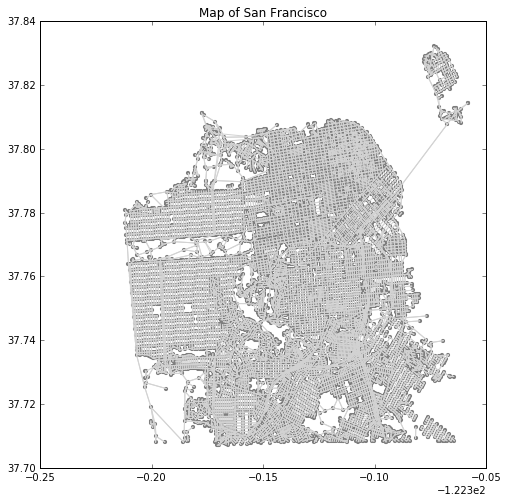

In [6]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
san_fran_map.plot_graph(ax=ax)
ax.set_title('Map of San Francisco')
plt.show()

### Section 1: Graph Search - A*

**Cambridge**

In [7]:
# randomly select a start and an end point on the graph for test
intersection_graph = cambridge_map.intersection_graph
start = intersection_graph[np.random.choice(intersection_graph.keys())]
end = intersection_graph[np.random.choice(intersection_graph.keys())]

In [8]:
# search the graph
route = cambridge_map.a_star_search(start,
                                   end,
                                   road_cost=cambridge_map.get_road_cost,
                                   heuristic=cambridge_map.null_heuristic)
safe_route = cambridge_map.a_star_search(start,
                                   end,
                                   road_cost=cambridge_map.get_safe_road_cost,
                                   heuristic=cambridge_map.null_heuristic)

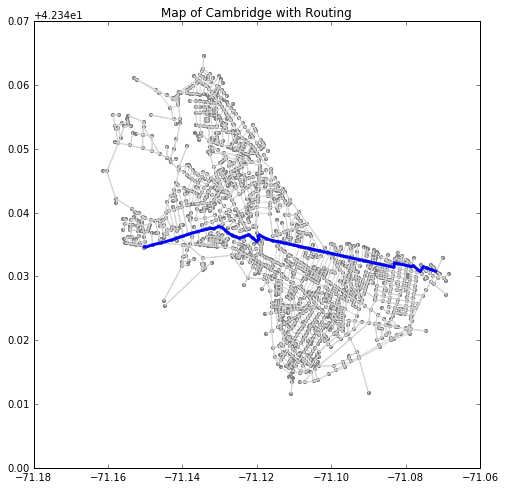

In [9]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
cambridge_map.plot_graph([], [route['nodes']], ax=ax)
ax.set_title('Map of Cambridge with Routing')
plt.show()

**San Francisco**

In [10]:
# randomly select a start and an end point on the graph for test
intersection_graph = san_fran_map.intersection_graph
start = intersection_graph[np.random.choice(intersection_graph.keys())]
end = intersection_graph[np.random.choice(intersection_graph.keys())]

In [11]:
# search the graph
route = san_fran_map.a_star_search(start,
                                   end,
                                   road_cost=san_fran_map.get_road_cost,
                                   heuristic=san_fran_map.null_heuristic)
safe_route = san_fran_map.a_star_search(start,
                                   end,
                                   road_cost=san_fran_map.get_safe_road_cost,
                                   heuristic=san_fran_map.null_heuristic)

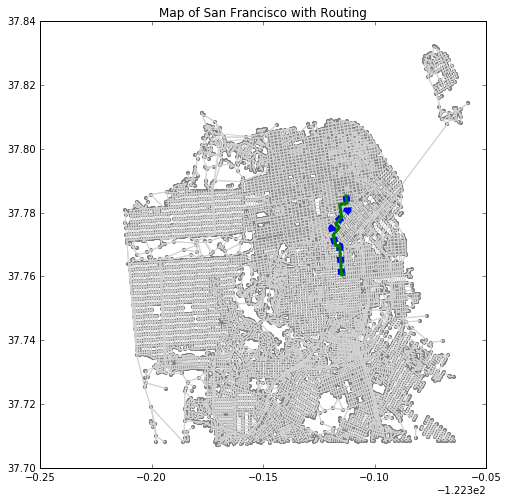

In [12]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
san_fran_map.plot_graph([route['nodes']], [safe_route['nodes']], ax=ax)
ax.set_title('Map of San Francisco with Routing')
plt.show()

**Lets collect some data:**

In [13]:
def sim(start, end, cost_fn, heuristic_fn, map_to_test):
    route, nodes_expanded = map_to_test.a_star_search(start,
                                   end,
                                   road_cost=cost_fn,
                                   heuristic=heuristic_fn,
                                   return_expanded_nodes = True)
    
    solution_distance = map_to_test.get_road_cost(route['nodes'], route['connections'])
    delta_elev = np.sum([np.abs(map_to_test.road_connections[conn].delta_elevation) for conn in route['connections']])
    return (route['nodes'], solution_distance, delta_elev, len(nodes_expanded))

def execute_simulation(nsims, cost_fn, heuristic_fn, map_to_test=san_fran_map):
    euclidean_dist = []
    solution_nodes = [[],[],[]]
    solution_route_distance = [[],[],[]]
    solution_delta_elevation = [[],[],[]]
    solution_nodes_expanded = [[],[],[]]

    for i in range(nsims):
        try:
            start = map_to_test.intersection_graph[np.random.choice(map_to_test.intersection_graph.keys())]
            end = map_to_test.intersection_graph[np.random.choice(map_to_test.intersection_graph.keys())]
            euclid_dist = 0
            while (end.id == start.id) or ((euclid_dist < 0.02) or (euclid_dist > 0.15)):
                end = map_to_test.intersection_graph[np.random.choice(map_to_test.intersection_graph.keys())]
                euclid_dist = euclidean_distance(start.get_x_y(), end.get_x_y())

            # under the null heuristic
            result0 = sim(start, end, cost_fn[0], heuristic_fn[0], map_to_test)

            # under the euclidean_heuristic heuristic
            result1 = sim(start, end, cost_fn[1], heuristic_fn[1], map_to_test)

            # under the combined_heuristic heuristic
            result2 = sim(start, end, cost_fn[2], heuristic_fn[2], map_to_test)
            
            euclidean_dist.append(euclid_dist)
            
            k = 0
            solution_nodes[k].append(result0[0])
            solution_route_distance[k].append(result0[1])
            solution_delta_elevation[k].append(result0[2])
            solution_nodes_expanded[k].append(result0[3])
            
            k = 1
            solution_nodes[k].append(result1[0])
            solution_route_distance[k].append(result1[1])
            solution_delta_elevation[k].append(result1[2])
            solution_nodes_expanded[k].append(result1[3])
            
            k = 2
            solution_nodes[k].append(result2[0])
            solution_route_distance[k].append(result2[1])
            solution_delta_elevation[k].append(result2[2])
            solution_nodes_expanded[k].append(result2[3])
        except:
            continue
        
    return euclidean_dist, solution_nodes, solution_route_distance, solution_delta_elevation, solution_nodes_expanded

#watch out for this number. The larger it is the longer this will all take!!! (100 is MASSIVE)
nsim = 50 # we used 100 for the experiments

### Basic road cost

In [14]:
# Cost function = get_road_cost ## I.e. simple road cost
cost_fn = [san_fran_map.get_road_cost, san_fran_map.get_road_cost, san_fran_map.get_road_cost]
heuristic = [san_fran_map.null_heuristic, san_fran_map.euclidean_heuristic, san_fran_map.combined_heuristic]

result = execute_simulation(nsim, cost_fn, heuristic, san_fran_map)

euclidean_dist = np.array(result[0])
solution_nodes = result[1]
solution_route_distance = result[2]
solution_delta_elevation = result[3]
solution_nodes_expanded = result[4]

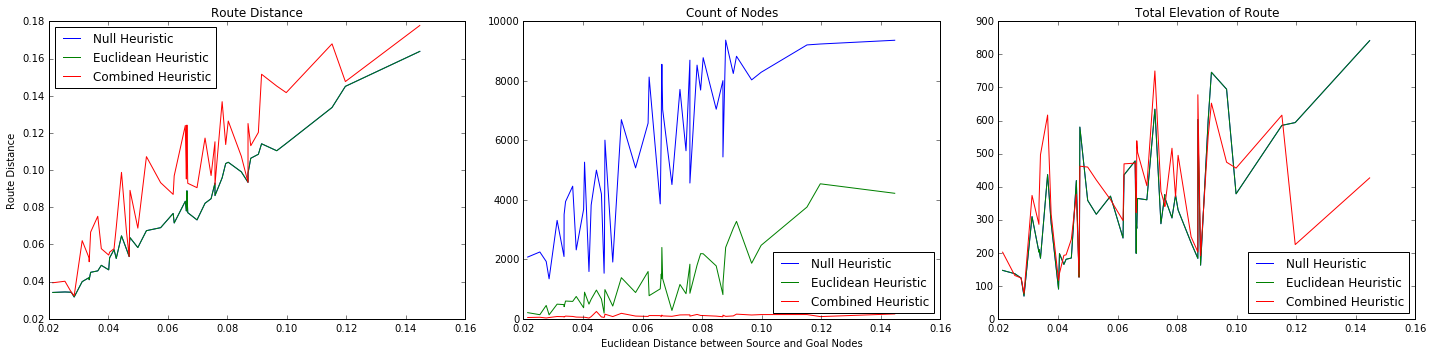

In [15]:
fig, ax = plt.subplots(1,3, figsize=(20,5))

labels = ['Null Heuristic', 'Euclidean Heuristic', 'Combined Heuristic']
arg_sort = np.argsort(euclidean_dist).astype(np.int32)
solution_route_distance = np.array(solution_route_distance)
for i in range(3):
    ax[0].plot(euclidean_dist[arg_sort], solution_route_distance[i][arg_sort], label=labels[i])

solution_nodes_expanded = np.array(solution_nodes_expanded)
for i in range(3):
    ax[1].plot(euclidean_dist[arg_sort], solution_nodes_expanded[i][arg_sort], label=labels[i])
    
solution_delta_elevation = np.array(solution_delta_elevation)
for i in range(3):
    ax[2].plot(euclidean_dist[arg_sort], np.abs(solution_delta_elevation[i][arg_sort]), label=labels[i])

ax[0].set_title('Route Distance')
ax[1].set_title('Number of Nodes Visited')
ax[2].set_title('Total Elevation of Route')

ax[1].set_xlabel('Euclidean Distance between Source and Goal Nodes')
ax[0].set_ylabel('Route Distance')
ax[1].set_title('Count of Nodes')
ax[2].set_title('Total Elevation of Route')

ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[2].legend(loc='best')

fig.tight_layout()
plt.show()

### Safe Road Cost

In [16]:
# Cost function = euclidean_heuristic ## I.e. simple road cost
cost_fn = [san_fran_map.get_safe_road_cost, san_fran_map.get_safe_road_cost, san_fran_map.get_safe_road_cost]
result = execute_simulation(nsim, cost_fn, heuristic, san_fran_map)

euclidean_dist = np.array(result[0])
solution_nodes = result[1]
solution_route_distance = result[2]
solution_delta_elevation = result[3]
solution_nodes_expanded = result[4]

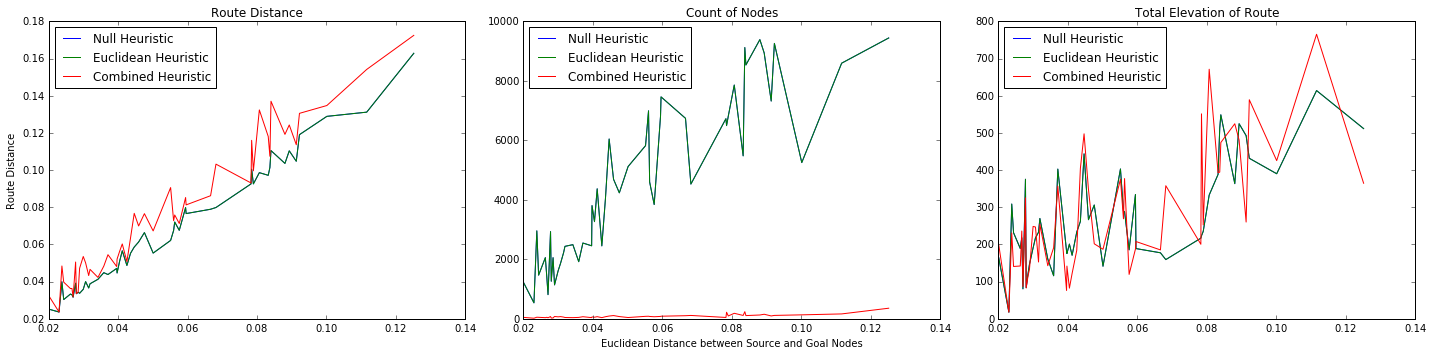

In [17]:
fig, ax = plt.subplots(1,3, figsize=(20,5))

euclidean_dist = np.array(euclidean_dist)
labels = ['Null Heuristic', 'Euclidean Heuristic', 'Combined Heuristic']
arg_sort = np.argsort(euclidean_dist).astype(np.int32)

solution_route_distance = np.array(solution_route_distance)
for i in range(3):
    ax[0].plot(euclidean_dist[arg_sort], solution_route_distance[i][arg_sort], label=labels[i])

solution_nodes_expanded = np.array(solution_nodes_expanded)
for i in range(3):
    ax[1].plot(euclidean_dist[arg_sort], solution_nodes_expanded[i][arg_sort], label=labels[i])
    
solution_delta_elevation = np.array(solution_delta_elevation)
for i in range(3):
    ax[2].plot(euclidean_dist[arg_sort], np.abs(solution_delta_elevation[i][arg_sort]), label=labels[i])

ax[0].set_title('Route Distance')
ax[1].set_title('Number of Nodes Visited')
ax[2].set_title('Total Elevation of Route')

ax[1].set_xlabel('Euclidean Distance between Source and Goal Nodes')
ax[0].set_ylabel('Route Distance')
ax[1].set_title('Count of Nodes')
ax[2].set_title('Total Elevation of Route')

ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[2].legend(loc='best')

fig.tight_layout()
plt.show()

### Safe Road Cost with Elevation

In [18]:
# Cost function = euclidean_heuristic ## I.e. simple road cost
heuristic = [san_fran_map.null_heuristic, san_fran_map.euclidean_heuristic, san_fran_map.combined_heuristic]
cost_fn = [san_fran_map.get_safe_road_cost_with_elevation,
           san_fran_map.get_safe_road_cost_with_elevation,
           san_fran_map.get_safe_road_cost_with_elevation]
result = execute_simulation(nsim, cost_fn, heuristic, san_fran_map)

euclidean_dist = result[0]
solution_nodes = result[1]
solution_route_distance = result[2]
solution_delta_elevation = result[3]
solution_nodes_expanded = result[4]

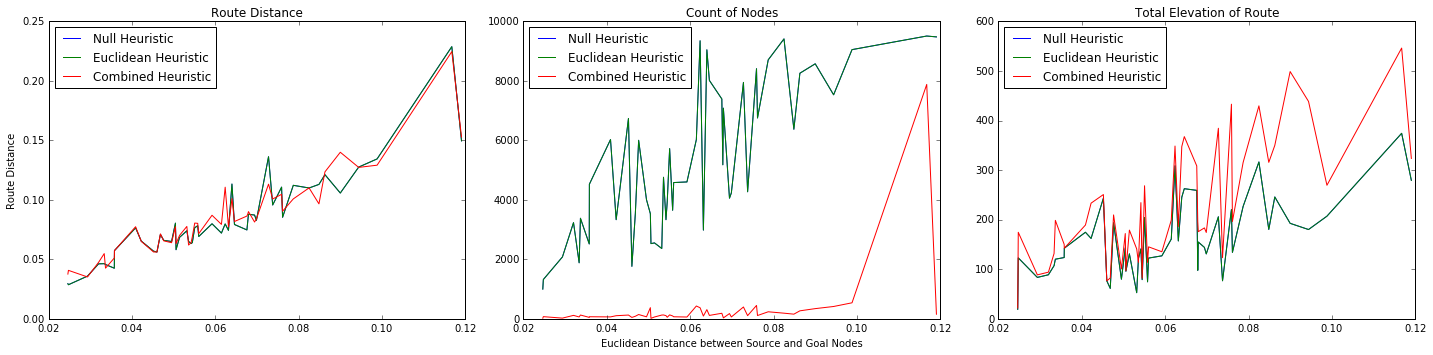

In [19]:
fig, ax = plt.subplots(1,3, figsize=(20,5))

euclidean_dist = np.array(euclidean_dist)
labels = ['Null Heuristic', 'Euclidean Heuristic', 'Combined Heuristic']
arg_sort = np.argsort(euclidean_dist).astype(np.int32)

solution_route_distance = np.array(solution_route_distance)
for i in range(3):
    ax[0].plot(euclidean_dist[arg_sort], solution_route_distance[i][arg_sort], label=labels[i])

solution_nodes_expanded = np.array(solution_nodes_expanded)
for i in range(3):
    ax[1].plot(euclidean_dist[arg_sort], solution_nodes_expanded[i][arg_sort], label=labels[i])
    
solution_delta_elevation = np.array(solution_delta_elevation)
for i in range(3):
    ax[2].plot(euclidean_dist[arg_sort], np.abs(solution_delta_elevation[i][arg_sort]), label=labels[i])

ax[0].set_title('Route Distance')
ax[1].set_title('Number of Nodes Visited')
ax[2].set_title('Total Elevation of Route')

ax[1].set_xlabel('Euclidean Distance between Source and Goal Nodes')
ax[0].set_ylabel('Route Distance')
ax[1].set_title('Count of Nodes')
ax[2].set_title('Total Elevation of Route')

ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[2].legend(loc='best')

fig.tight_layout()
plt.show()

In [20]:
cost_fn = [san_fran_map.get_road_cost, san_fran_map.get_safe_road_cost, san_fran_map.get_safe_road_cost_with_elevation]
heuristic = [san_fran_map.null_heuristic, san_fran_map.null_heuristic, san_fran_map.null_heuristic]

result = execute_simulation(100, cost_fn, heuristic, san_fran_map)

euclidean_dist = result[0]
solution_nodes = result[1]
solution_route_distance = result[2]
solution_delta_elevation = result[3]
solution_nodes_expanded = result[4]

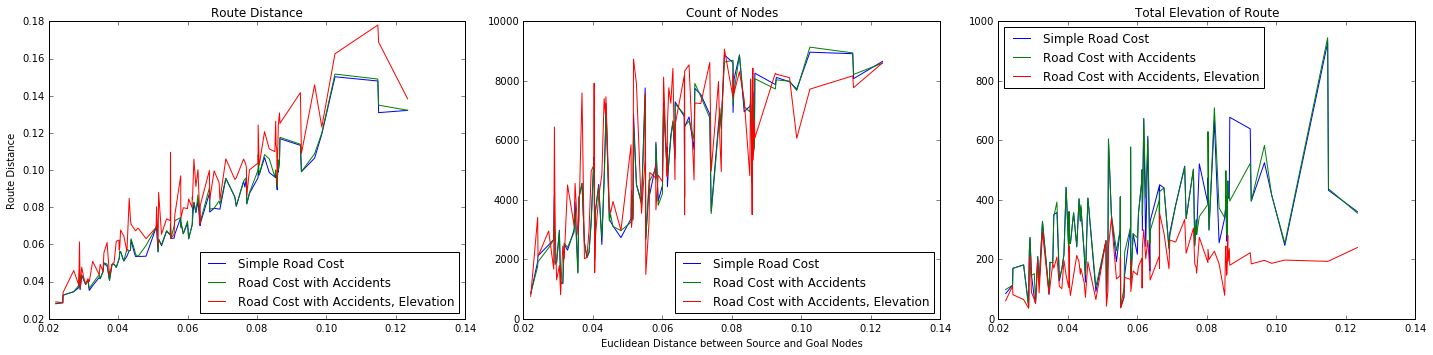

In [21]:
## Compare cost function 
fig, ax = plt.subplots(1,3, figsize=(20,5))

euclidean_dist = np.array(euclidean_dist)
labels = ['Simple Road Cost', 'Road Cost with Accidents', 'Road Cost with Accidents, Elevation']
arg_sort = np.argsort(euclidean_dist).astype(np.int32)

solution_route_distance = np.array(solution_route_distance)
for i in range(3):
    ax[0].plot(euclidean_dist[arg_sort], solution_route_distance[i][arg_sort], label=labels[i])

solution_nodes_expanded = np.array(solution_nodes_expanded)
for i in range(3):
    ax[1].plot(euclidean_dist[arg_sort], solution_nodes_expanded[i][arg_sort], label=labels[i])
    
solution_delta_elevation = np.array(solution_delta_elevation)
for i in range(3):
    ax[2].plot(euclidean_dist[arg_sort], np.abs(solution_delta_elevation[i][arg_sort]), label=labels[i])

ax[0].set_title('Route Distance')
ax[1].set_title('Number of Nodes Visited')
ax[2].set_title('Total Elevation of Route')

ax[1].set_xlabel('Euclidean Distance between Source and Goal Nodes')
ax[0].set_ylabel('Route Distance')
ax[1].set_title('Count of Nodes')
ax[2].set_title('Total Elevation of Route')

ax[0].legend(loc='best')
ax[1].legend(loc='best')
ax[2].legend(loc='best')

fig.tight_layout()
plt.show()

### Local Search: Simulated Annealing, K-Beam

In [22]:
intersection_graph = cambridge_map.intersection_graph
start = intersection_graph[np.random.choice(intersection_graph.keys())]
end = intersection_graph[np.random.choice(intersection_graph.keys())]

route = cambridge_map.a_star_search(start, end, cambridge_map.get_road_cost, cambridge_map.null_heuristic)

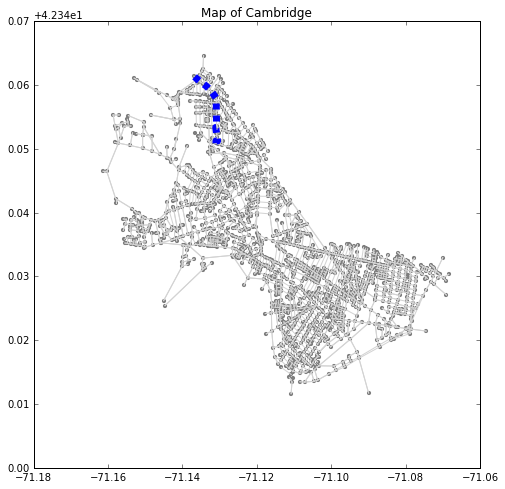

In [23]:
fig, ax = plt.subplots(1,1, figsize=(8,8))
cambridge_map.plot_graph([route['nodes']], ax=ax)
ax.set_title('Map of Cambridge')
plt.show()

In [26]:
import time
# define which map type you want to run
test_map = cambridge_map

p1 = test_map.intersection_graph[np.random.choice(test_map.intersection_graph.keys())]
p2 = test_map.intersection_graph[np.random.choice(test_map.intersection_graph.keys())]
p3 = test_map.intersection_graph[np.random.choice(test_map.intersection_graph.keys())]
p4 = test_map.intersection_graph[np.random.choice(test_map.intersection_graph.keys())]
points = [p1,p2,p3,p4]

heuristic_fns = [test_map.null_heuristic, test_map.euclidean_heuristic, test_map.combined_heuristic]
times_annealing = []
times_k_beam = []
costs_annealing = []
costs_k_beam = []

for fn in heuristic_fns:
    try:
        # start time annealing
        start = time.clock()
        node_annealing = test_map.simulated_annealing(
                    cost_function=test_map.get_road_cost,
                    heuristic=fn,
                    starting_points=points)

        # annealing time
        timer_annealing = time.clock() - start

        # annealing costs
        cost = np.sum([test_map.cost(p, node_annealing, test_map.get_road_cost, fn) for p in points])

        # start time
        start = time.clock()
        node_k_beam, best_cost, k_points = test_map.k_beam_search(k=5,
                    cost_function=test_map.get_road_cost,
                    heuristic=fn,
                    starting_points=points)

        # k beam time
        timer_k_beam = time.clock() - start

        # k beam costs
        cost = np.sum([test_map.cost(p, node_k_beam, test_map.get_road_cost, fn) for p in points])

        #save iteration
        times_annealing.append(timer_annealing)
        costs_annealing.append(cost)
        times_k_beam.append(timer_k_beam)
        costs_k_beam.append(cost)
    except:
        continue

iteration  0 best cost 0.0825696739034
iteration  1 best cost 0.0807049502129
iteration  0 best cost 0.0818488846339
iteration  0 best cost 0.0899404290121


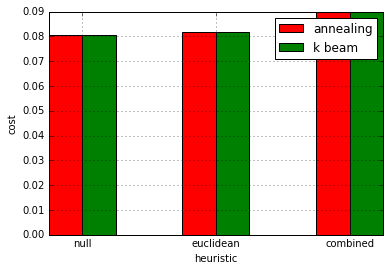

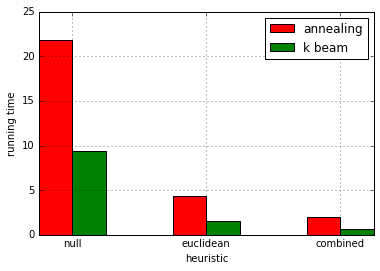

In [30]:
w = 0.25

x_ticks = [0,1,2]

plt.bar(x_ticks, costs_annealing, 0.25, color = 'r', label = 'annealing')
plt.bar([x + w for x in x_ticks], costs_k_beam, 0.25, color = 'g', label = 'k beam')
plt.grid(True)
plt.ylabel('cost')
plt.legend(loc='best')
plt.xlabel('heuristic')
plt.xticks([0+w,1+w,2+w], ['null', 'euclidean', 'combined'])

plt.figure()
plt.bar(x_ticks, times_annealing, 0.25, color = 'r', label = 'annealing')
plt.bar([x + w for x in x_ticks], times_k_beam, 0.25, color = 'g', label = 'k beam')
plt.grid(True)
plt.ylabel('running time')
plt.legend(loc='best')
plt.xlabel('heuristic')
plt.xticks([0+w,1+w,2+w], ['null', 'euclidean', 'combined'])
plt.show()

In [31]:
test_map = cambridge_map

p1 = test_map.intersection_graph[np.random.choice(test_map.intersection_graph.keys())]
p2 = test_map.intersection_graph[np.random.choice(test_map.intersection_graph.keys())]
p3 = test_map.intersection_graph[np.random.choice(test_map.intersection_graph.keys())]
p4 = test_map.intersection_graph[np.random.choice(test_map.intersection_graph.keys())]
points = [p1,p2,p3,p4]

times_k_beam = []
costs_k_beam = []
ks = np.linspace(5,35,10)

# iterate through the beam widths

for k in ks:
    k_cost = []
    k_time = []
    # run 10 iterations for each value of k and average
    
    for index in range(5):
        try:
            k = int(k)
            start = time.clock()

            # run k beam search
            node_k_beam, best_cost, k_points = test_map.k_beam_search(k=k,
                        cost_function=test_map.get_road_cost,
                        heuristic=test_map.null_heuristic,
                        starting_points=points)
            timer = time.clock() - start

            # calculate cost
            cost = np.sum([test_map.cost(p, node_k_beam, test_map.get_road_cost, test_map.null_heuristic) for p in points])

            # save time and cost
            k_time.append(timer)
            k_cost.append(cost)
        except:
            continue
        
    times_k_beam.append(np.mean(k_time))
    costs_k_beam.append(np.mean(k_cost))

iteration  0 best cost 0.0861683115493
iteration  1 best cost 0.0850982491877
iteration  2 best cost 0.0837033804306
iteration  0 best cost 0.0856316518392
iteration  0 best cost 0.0882152540926
iteration  0 best cost 0.0875008117059
iteration  1 best cost 0.0863097831193
iteration  2 best cost 0.0863097831193
iteration  0 best cost 0.0868816422863
iteration  1 best cost 0.0855030050913
iteration  2 best cost 0.0837033804306
iteration  0 best cost 0.0876305130741
iteration  1 best cost 0.0845708809154
iteration  2 best cost 0.0841805205036
iteration  0 best cost 0.0888413956259
iteration  1 best cost 0.0875788051596
iteration  2 best cost 0.0850982491877
iteration  0 best cost 0.0837033804306
iteration  0 best cost 0.0863097831193
iteration  0 best cost 0.0863097831193
iteration  0 best cost 0.0876305130741
iteration  1 best cost 0.0863097831193
iteration  0 best cost 0.0863056805297
iteration  0 best cost 0.0858158903387
iteration  1 best cost 0.0841805205036
iteration  0 best cost 0.

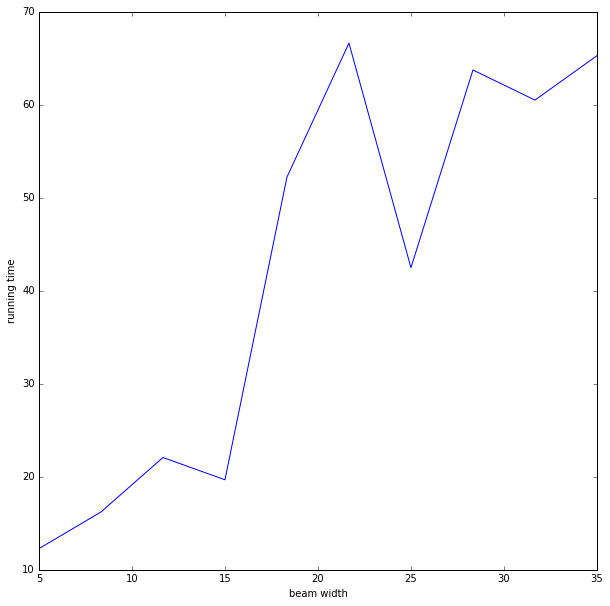

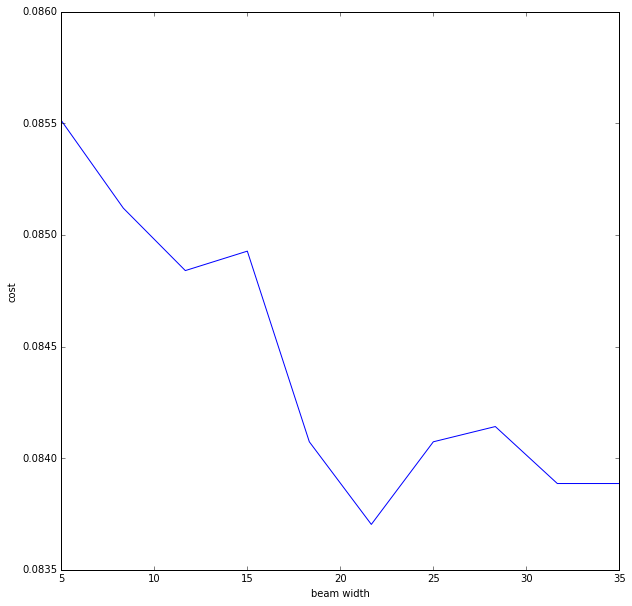

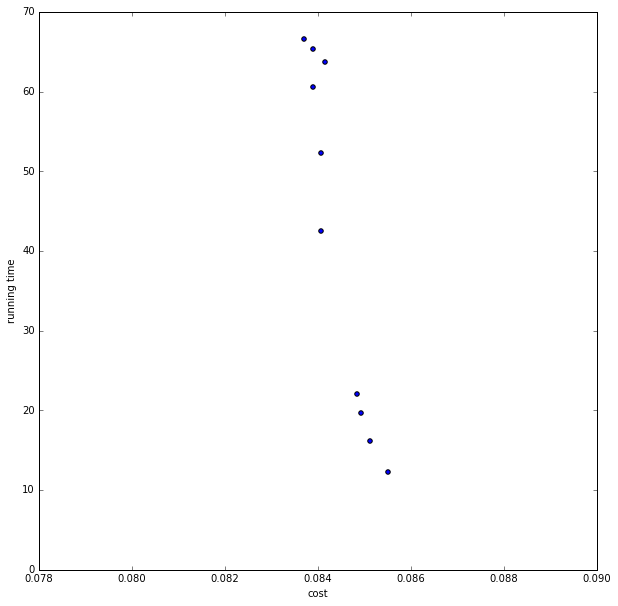

In [32]:
plt.figure(figsize=(10,10))
plt.plot(np.linspace(5,35,10), times_k_beam)
plt.xlabel('beam width')
plt.ylabel('running time')


plt.figure(figsize=(10,10))
plt.plot(np.linspace(5,35,10), costs_k_beam)
plt.xlabel('beam width')
plt.ylabel('cost')

plt.figure(figsize=(10,10))
plt.scatter(costs_k_beam, times_k_beam)
plt.xlabel('cost')
plt.ylabel('running time')